![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Face Mask Prediction using U-Net
Task is to predict the mask around the face in a given image.

# Instructions
- Some part of the code is already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [11]:
#### Add your code here ####
import csv
import math
import cv2
from google.colab import drive
import os
import datetime

import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
os.getcwd()

'/content'

In [7]:
os.chdir('/content/drive/MyDrive/ACC/')

In [8]:
os.getcwd()

'/content/drive/MyDrive/ACC'

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [9]:
data = np.load('images.npy', allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)
- Hint: print data[10][1] 

In [10]:
for key in data:
    print (key)
    print (data[10][1])
    break

[array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)
 list([{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.306306

### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [12]:
#### Add your code here ####
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [13]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [14]:
print ('Shape of X  : ',X.shape)

Shape of X  :  (409, 224, 224, 3)


In [15]:
print ('Shape of masks  : ',masks.shape)

Shape of masks  :  (409, 224, 224)


### Split the data into training and testing (2 marks)
- 400 images in training
- 9 images in testing data

Training data

In [16]:
train_size = int(len(X)) - 9
print(train_size)

400


In [17]:
X_train = X[:400]#### Add your code here ####
y_train = masks[:400]#### Add your code here ####
print ('Shape of X_Train  : ',X_train.shape)
print ('Shape of y_Train  : ',y_train.shape)

Shape of X_Train  :  (400, 224, 224, 3)
Shape of y_Train  :  (400, 224, 224)


Testing data

In [18]:
X_test = X[-9:]    #### Add your code here ####
y_test = masks[-9:]  #### Add your code here ####
print ('Shape of X_Test  : ',X_test.shape)
print ('Shape of y_Test  : ',y_test.shape)

Shape of X_Test  :  (9, 224, 224, 3)
Shape of y_Test  :  (9, 224, 224)


### Print a sample training image, image array and its mask (2 marks)

Print the image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

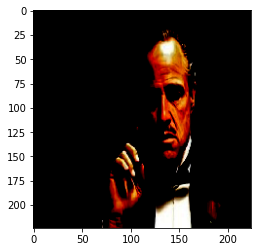

In [19]:
#### Add your code here ####
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

Print the mask

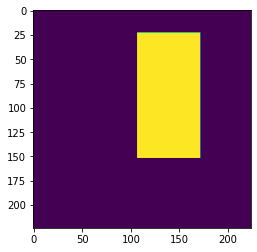

In [20]:
#### Add your code here ####
pyplot.imshow(y_train[n])

In [22]:
ab = np.reshape(y_train[n], y_train[n].shape + (1,))
ab.shape

(224, 224, 1)

## Create the model (5 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [25]:
def create_model(trainable=True):
    model =MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable
    #### Add your code here ####
    # Add all the UNET layers here
    
    block1 = model.get_layer("conv_pw_5_relu").output #28
    block2 = model.get_layer("conv_pw_11_relu").output #14
    block3 = model.get_layer("conv_pw_13_relu").output #7
    block4 = model.get_layer("conv_pw_3_relu").output #56
    block5 = model.get_layer("conv_pw_1_relu").output #112
    
    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block4])
    x = Concatenate()([UpSampling2D()(x), block5])
    # Upsampling is done to match the output size with the size of the lables 224 by 224 in this case.
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="relu")(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function (1 mark)
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [26]:
#### Add your code here ####
model = create_model()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
_____________________________

### Print model summary (1 mark)

In [27]:
#### Add your code here ####
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

### Define dice coefficient function (2 marks)
- Create a function to calculate dice coefficient


In [28]:
#### Add your code here ####

#### Add your code here ####
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss function (2 marks)

In [29]:
#### Add your code here ####
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [30]:
#### Add your code here ####
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define callbacks (2 marks)
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [31]:
#### Add your code here ####
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [32]:
#### Add your code here ####
model.fit(X_train,y_train,
                    epochs=200,
                    callbacks=[checkpoint, reduce_lr, stop],
                    workers=1,batch_size=1,
                    use_multiprocessing=False,
                    shuffle=True,
                    verbose=1)

Epoch 1/200
400/400 [==============================] - 28s 45ms/step - loss: 1.8047 - dice_coefficient: 0.2830

Epoch 00001: loss improved from inf to 1.59050, saving model to model-1.59.h5
Epoch 2/200
400/400 [==============================] - 18s 46ms/step - loss: 1.2226 - dice_coefficient: 0.4031

Epoch 00002: loss improved from 1.59050 to 1.20403, saving model to model-1.20.h5
Epoch 3/200
400/400 [==============================] - 18s 46ms/step - loss: 0.9955 - dice_coefficient: 0.4713

Epoch 00003: loss improved from 1.20403 to 1.04176, saving model to model-1.04.h5
Epoch 4/200
400/400 [==============================] - 18s 46ms/step - loss: 0.9365 - dice_coefficient: 0.4875

Epoch 00004: loss improved from 1.04176 to 0.94207, saving model to model-0.94.h5
Epoch 5/200
400/400 [==============================] - 18s 46ms/step - loss: 0.8931 - dice_coefficient: 0.5100

Epoch 00005: loss improved from 0.94207 to 0.88587, saving model to model-0.89.h5
Epoch 6/200
400/400 [=============

dict_keys(['loss', 'dice_coefficient', 'lr'])


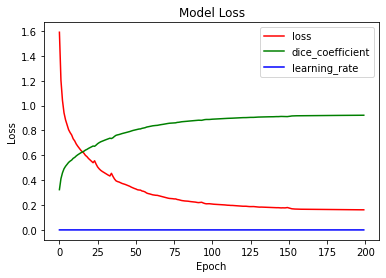

In [33]:
# list all data in history
print(model.history.history.keys())

# Summary - History for loss

pyplot.plot(model.history.history['loss'], color = 'red')
pyplot.plot(model.history.history['dice_coefficient'], color = 'green')
pyplot.plot(model.history.history['lr'], color = 'blue')
pyplot.title('Model Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['loss', 'dice_coefficient', 'learning_rate'], loc='upper right')
pyplot.show();

### Get the predicted mask for a test image   (2 marks)

Show the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


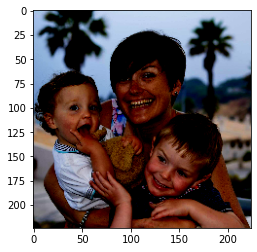

In [34]:
#### Add your code here ####
n = 0
pyplot.imshow(X_test[n])

Show original mask for test image

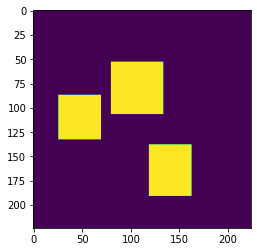

In [35]:
#### Add your code here ####
pyplot.imshow(y_test[n])

Predict the mask on the test image

In [36]:
#### Add your code here ####
sample_image = X_test[n]
img = np.array([sample_image])
# Predicted Mask for a sample image
predicted_mask = model.predict(img)[0]
predicted_mask = np.reshape(predicted_mask, (224,224))

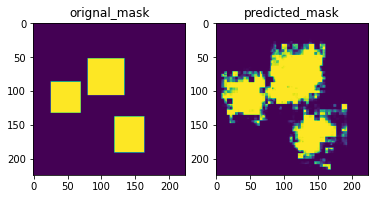

In [37]:
fig, (ax,ax1) = pyplot.subplots(1,2)
ax1.set_title('predicted_mask')
ax1.imshow(predicted_mask)
ax.set_title('orignal_mask')
ax.imshow(y_test[n])

### Impose the mask on the test image (2 marks)
- In imshow use the alpha parameter and set it to greater than 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


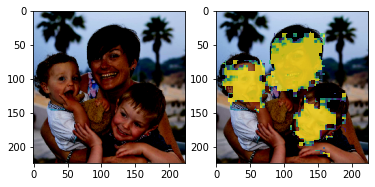

In [38]:
#### Add your code here ####
masked = np.ma.masked_where(predicted_mask < 0.1, predicted_mask)
pyplot.figure()
pyplot.subplot(1,2,1)
pyplot.imshow(sample_image)
pyplot.subplot(1,2,2)
pyplot.imshow(sample_image)
pyplot.imshow(masked, alpha=0.8)
pyplot.show()